In [0]:
import copy
import numpy as np
import sklearn
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from keras.utils import to_categorical
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Input,Reshape,UpSampling2D
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics.cluster import normalized_mutual_info_score
from keras.callbacks import History
from sklearn.linear_model import LogisticRegression
from keras.models import Model,Sequential
from sklearn.metrics import accuracy_score


# Read Fashion MNIST dataset using Keras
fashion_mnist = keras.datasets.fashion_mnist
(X_train, Y_train), (X_test,Y_test) = fashion_mnist.load_data() 

# Normalize the dataset
X_train = (X_train / 255.0)
X_test = (X_test / 255.0)
X_train = np.float32(X_train)
X_test = np.float32(X_test)

# Rescale the training and testing data with the maximum pixel value 
# in the respective data sets
X_train = X_train / np.max(X_train)
X_test = X_test / np.max(X_test)


SSE for #cluster =  1 is 4092975.6596677564
SSE for #cluster =  2 is 3233032.0676284176
SSE for #cluster =  3 is 2766659.5236280463
SSE for #cluster =  4 is 2505225.873973058
SSE for #cluster =  5 is 2352605.66958883
SSE for #cluster =  6 is 2202642.5083292704
SSE for #cluster =  7 is 2099373.5016917875


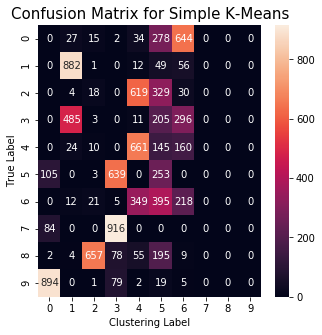

SIMPLE K-MEANS MODEL ACCURACY: 0.5186884775727859
CLASSIFICATION REPORT
----------------------------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.61      0.88      0.72      1000
           2       0.02      0.02      0.02      1000
           3       0.00      0.00      0.00      1000
           4       0.38      0.66      0.48      1000
           5       0.14      0.25      0.18      1000
           6       0.15      0.22      0.18      1000
           7       0.00      0.00      0.00      1000
           8       0.00      0.00      0.00      1000
           9       0.00      0.00      0.00      1000

    accuracy                           0.20     10000
   macro avg       0.13      0.20      0.16     10000
weighted avg       0.13      0.20      0.16     10000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [38]:
# Task 1 : Simple K-Means Clustering Model Implementation
# Read Fashion MNIST dataset using Keras
(X_train, Y_train), (X_test,Y_test) = fashion_mnist.load_data()
# Count the number of unique labels 
clusters = len(np.unique(Y_train))

# Reshaping the training and test dataset
nsamples_train, nx_train, ny_train = X_train.shape
X_train = X_train.reshape((nsamples_train, nx_train * ny_train))
nsamples_test, nx_test, ny_test = X_test.shape
X_test = X_test.reshape((nsamples_test, nx_test * ny_test))

# Normalizing the train and test feature vector
X_train = (X_train / 255.0)
X_test = (X_test / 255.0)

train_loss = []

# Training the clustering model for different k-values and calculating the SSE
for n in range(1,11):
  #Run in four parallel Processors n_jobs=4
  kmeans = KMeans(n_clusters=n, random_state=42, n_init=20, n_jobs=4, max_iter=600)
  kmeans.fit(X_train)
  sse = kmeans.inertia_ 
  train_loss.append(sse)
  print('SSE for #cluster = ', n, 'is',sse)

# Validating the clustering model using test dataset
labels_pred = kmeans.fit_predict(X_test)

# Fetching the Cluster Centroids
centroids = kmeans.cluster_centers_

# Compare the predicted clustering result with original labels 
# using the confusion matrix
cm = confusion_matrix(Y_test, labels_pred)

# Visualizing the data clusters
plt.figure(figsize=(5, 5))
ax = sns.heatmap(cm, annot=True, fmt="d")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Confusion Matrix for Simple K-Means", fontsize=15)
plt.ylabel('True Label', fontsize=10)
plt.xlabel('Clustering Label', fontsize=10)
plt.show()

# Calculating the Accuracy
test_score = normalized_mutual_info_score(y_test,labels_pred)
print('SIMPLE K-MEANS MODEL ACCURACY: '+str(test_score))

# Generating the classification report
print("CLASSIFICATION REPORT")
print("----------------------------------------------------")
print(classification_report(Y_test,labels_pred))

In [41]:
# Task 2 : Implementing a Convolutional Autoencoder

# Reshaping the train and test feature vector
X_train = X_train.reshape((len(X_train), 28, 28, 1))
X_test = X_test.reshape((len(X_test), 28, 28, 1))

# Calculating the Compression Factor 
input_dim = X_train.shape[1]
encoding_dim = 32
compression_factor = float(input_dim) / encoding_dim
print("Compression Factor: %s" % compression_factor)

# Defining the autoencoder model
autoencoder = Sequential()

# Encoder Layers
autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=X_train.shape[1:]))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(Conv2D(8, (3, 3), strides=(2,2), activation='relu', padding='same'))

# Flatten encoding for visualization
autoencoder.add(Flatten())
autoencoder.add(Reshape((4, 4, 8)))

# Decoder Layers
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(16, (3, 3), activation='relu'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

autoencoder.summary()


Compression Factor: 0.875
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 4, 4, 8)           584       
_________________________________________________________________
flatten_8 (Flatten)          (None, 128)               0         
_________________________________________________________________
reshape_8 (Reshape)         

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50_input (InputLayer) (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 4, 4, 8)           584       
_________________________________________________________________
flatten_8 (Flatten)          (None, 128)               0   

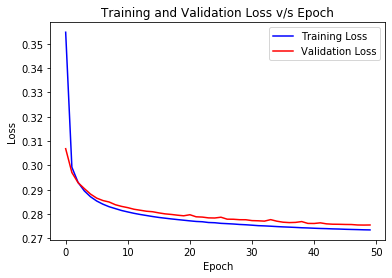

In [43]:
# Extracting the Encoder layer for Autoencoder based K-Means and GMM
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('flatten_8').output)
encoder.summary()

# Training the Autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_train = autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=128,
                validation_data=(X_test, X_test))

# Trainig loss and Validation loss graph plot
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(50)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss',color = 'red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss v/s Epoch')
plt.legend()
plt.show()

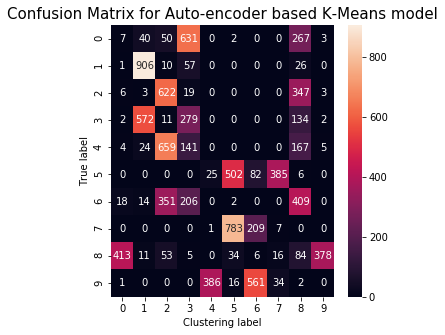

AUTO-ENCODER BASED K-MEANS MODEL ACCURACY: 0.5063173080535722
CLASSIFICATION REPORT
----------------------------------------------------
              precision    recall  f1-score   support

           0       0.03      0.04      0.03      1000
           1       0.08      0.09      0.08      1000
           2       0.00      0.00      0.00      1000
           3       0.04      0.04      0.04      1000
           4       0.00      0.00      0.00      1000
           5       0.00      0.00      0.00      1000
           6       0.03      0.04      0.03      1000
           7       0.00      0.00      0.00      1000
           8       0.94      0.36      0.53      1000
           9       0.65      0.60      0.62      1000

    accuracy                           0.12     10000
   macro avg       0.18      0.12      0.13     10000
weighted avg       0.18      0.12      0.13     10000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [44]:
# Task 3 : Implementing Autoencoder based K-Means Clustering
# Fetching the encoded version of the training feature vector
encoded_train = encoder.predict(X_train)

# Training the Clustering model using the training data set
kmeans = KMeans(n_clusters=10).fit(encoded_train)

# Fetching the encoded version of the test feature vector
encoded_imgs = encoder.predict(X_test)

# Validating the Clustering model using the encoded test dataset
Y_pred = kmeans.fit_predict(encoded_imgs)

# Cluster Centroids for the test data set
centroids = kmeans.cluster_centers_

# Compare the predicted clustering result with original labels 
# using the confusion matrix
cm = confusion_matrix(Y_test, clustered_set)

# Visualizing the data using the Confusion Matrix
plt.figure(figsize=(5, 5))
ax = sns.heatmap(cm, annot=True, fmt="d")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Confusion Matrix for Auto-encoder based K-Means model", fontsize=15)
plt.ylabel('True label', fontsize=10)
plt.xlabel('Clustering label', fontsize=10)
plt.show()

# Calculating the Accuracy
test_accuracy = normalized_mutual_info_score(Y_test,Y_pred)
print('AUTO-ENCODER BASED K-MEANS MODEL ACCURACY: '+str(test_accuracy))

# Generating the classification report
print("CLASSIFICATION REPORT")
print("----------------------------------------------------")
print(classification_report(Y_test,Y_pred))

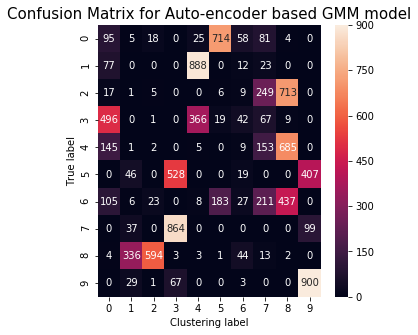

AUTO-ENCODER BASED GMM MODEL ACCURACY: 0.5912614497142512
CLASSIFICATION REPORT
----------------------------------------------------
              precision    recall  f1-score   support

           0       0.10      0.10      0.10      1000
           1       0.00      0.00      0.00      1000
           2       0.01      0.01      0.01      1000
           3       0.00      0.00      0.00      1000
           4       0.00      0.01      0.00      1000
           5       0.00      0.00      0.00      1000
           6       0.12      0.03      0.04      1000
           7       0.00      0.00      0.00      1000
           8       0.00      0.00      0.00      1000
           9       0.64      0.90      0.75      1000

    accuracy                           0.10     10000
   macro avg       0.09      0.10      0.09     10000
weighted avg       0.09      0.10      0.09     10000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [45]:
# Task 4 : Autoencoder based Gaussian Mixture Model
# Fetching the encoded version of the training feature vector
encoded_imgs_train = encoder.predict(X_train)

# Training the GMM Clustering model using the training data set with 10 clusters
gmm = GaussianMixture(n_components=10).fit(encoded_imgs_train)

#  Fetching the encoded version of test feature vector
encoded_imgs_test = encoder.predict(X_test)

# Validating the Clustering model
Y_pred_gmm = gmm.fit_predict(encoded_imgs_test)

# Calculating the cluster membership probabilities
proba_lists = gmm.predict_proba(encoded_imgs_test)
#print(proba_lists)

# Compare the predicted clustering result with original labels 
# using the confusion matrix
cm = confusion_matrix(Y_test, Y_pred_gmm)

# Visualizing the data using the Confusion Matrix
plt.figure(figsize=(5, 5))
ax = sns.heatmap(cm, annot=True, fmt="d")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Confusion Matrix for Auto-encoder based GMM model", fontsize=15)
plt.ylabel('True label', fontsize=10)
plt.xlabel('Clustering label', fontsize=10)
plt.show()

# Calculating the Accuracy
test_accuracy = normalized_mutual_info_score(Y_test,Y_pred_gmm)
print('AUTO-ENCODER BASED GMM MODEL ACCURACY: '+str(test_accuracy))

# Generating the classification report
print("CLASSIFICATION REPORT")
print("----------------------------------------------------")
print(classification_report(Y_test,Y_pred_gmm))